# Generative Models and Dimensionality Reduction

This lecture is mostly about generative models, but I'll introduce a particular type of generative model that will help us see another aspect of dimensionality reduction along the way.

As physicists, when we think about data we tend to think about information that an experiment collects, such as momenta of electrons scattering off of one another, or the mass of a person falling into a large black hole. We tend to think of the physics of the objects themselves.

However, when we move to a computer it is more natural to think of data in terms of its representation on our computers. In that situation, one might think of a data space $M$, which could be discrete, or continuous, like for a manifold. This way of thinking has the advantage that it is inclusive of mathematical data, such as those associated to sharp mathematical definitions rather than numbers collected at an experiment.

In either case, whether its our experimental biases or our mathematical biases, we normally don't have data points for all of the potential data space $M$. Rather, our experiments or mathematical biases lead us to sample / collect data from a data distribution $\rho(M)$. Often, the data space $M$ lives in an ambient space $A$ that is (much) bigger, and it's easy to sample from $A$, but not from $M$.

Generative models are primarily about two things: 
1. learning to model some distribution or density $\rho(M)$ (which might be even more general than a "data distribution").
2. learning to sample from that distribution.

The first part is called density estimation, and the second part is called sampling.

# Autoencoder

Before we get to a generative model, we'll begin with the humble autoencoder, which is useful for dimensionality reduction.

We actually studied dimensionality reduction already, via principal component analysis (PCA). PCA is a linear dimensionality reduction technique, which means that it is a linear map $L: \mathbb{R}^n \to \mathbb{R}^m$ with $m < n$, where $m$ is the number of principal components. The map is chosen to maximize the variance of the data in the new space, and effectively compresses the information of the vectors in $\mathbb{R}^n$.

The autoencoder is a *nonlinear* dimensionality reduction technique. It is a neural network with a bottleneck layer, which is a layer with fewer neurons than the input or output layers. The network is trained to minimize the reconstruction error, which is the difference between the input and output of the network. The bottleneck layer forces the network to learn a compressed representation of the data, which is the output of the bottleneck layer.

For simplicity, we'll start with an autoencoder on a dataset called MNIST.

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 9.91M/9.91M [00:00<00:00, 29.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.30MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.51MB/s]


Let's show some data.

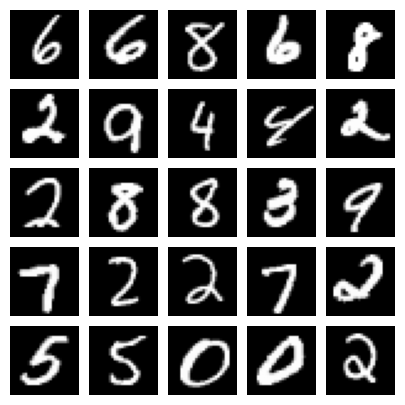

torch.Size([28, 28])

In [2]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

sample_images[0].shape

Now let's define the autoencoder. The forward pass of the NN, associated to the `forward` method, is the composition of an encoder NN and a decoder NN. The encoder compresses the data, and the decoder decompresses it to something of the same dimension as the input. For simplicity we'll just use fully connected networks for the encoder and decoder.

In [3]:
class AE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(AE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # decoder
        self.decoder = nn.Sequential(
            # nn.Linear(2, latent_dim),
            # nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        return self.encoder(x)
        # mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        # return mean, logvar

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x)), _, _
        # mean, logvar = self.encode(x)
        # z = self.reparameterization(mean, logvar)
        # x_hat = self.decode(z)
        # return x_hat, mean, log_var



We take the loss function to be the binary cross-entropy loss on the pixels, which have been normalized to be between $0$ and $1$, which is enforced in the decoder by the sigmoid function.

This loss is the so-called "reconstruction loss" of the autoencoder, which measures how well it reconstructs the input after passing it through a bottleneck.

In [4]:
def loss_function_AE(x, x_hat):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    return reproduction_loss

To train the autoencoder, we simply run the train loop across batches of data and backprop the reconstruction loss.

In [5]:
def train_AE(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, _, _ = model(x)
            loss = loss_function_AE(x, x_hat)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

Let's create our autoencoder.

In [6]:
model_AE = AE().to(device)
optimizer = Adam(model_AE.parameters(), lr=1e-3)

Let's compare the true images and the reconstructed image prior to training

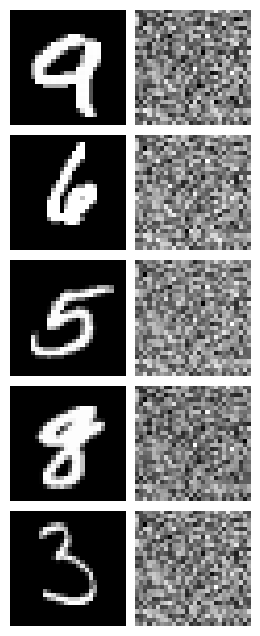

In [7]:
def print_data_and_samples(model_AE):
    x_dim = 784
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim).to(device)
        x_hat, _, _ = model_AE(x)

        x = x.detach().numpy().reshape(100,28,28)
        x_hat = x_hat.detach().numpy().reshape(100,28,28)
                            
        num_samples = 5
        samples = []
        for i in range(num_samples):
            samples.append(x[i])
            samples.append(x_hat[i])

        fig = plt.figure(figsize=(8,8))
        grid = ImageGrid(fig, 111, nrows_ncols=(num_samples, 2), axes_pad=0.1)

        for ax, im in zip(grid, samples):
            ax.imshow(im, cmap='gray')
            ax.axis('off')

        plt.show()

        break

print_data_and_samples(model_AE)

Yes, it looks terrible, as it should. Let's see what it looks like after epoch (which we remind you, passes through *all* of the data).

	Epoch 1 	Average Loss:  121.70965155141381


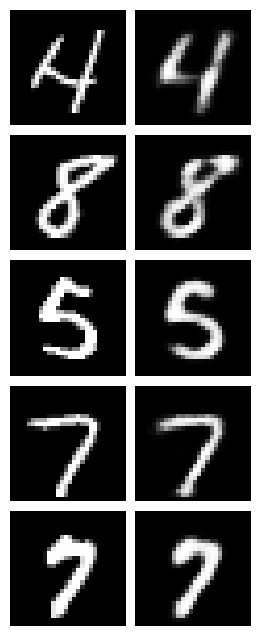

In [8]:
train_AE(model_AE, optimizer, epochs=1, device=device)
print_data_and_samples(model_AE)

This already looks quite good! Let's see what it looks like after 20 epochs.

	Epoch 1 	Average Loss:  70.17058801615974
	Epoch 2 	Average Loss:  63.04355486683535
	Epoch 3 	Average Loss:  59.90515786401816
	Epoch 4 	Average Loss:  58.041416969363
	Epoch 5 	Average Loss:  56.71717192227932
	Epoch 6 	Average Loss:  55.778359831489986
	Epoch 7 	Average Loss:  55.0553522716898
	Epoch 8 	Average Loss:  54.49758862426962
	Epoch 9 	Average Loss:  54.070068660984454
	Epoch 10 	Average Loss:  53.66595073820952
	Epoch 11 	Average Loss:  53.345263044201275
	Epoch 12 	Average Loss:  53.09308552176805
	Epoch 13 	Average Loss:  52.84753492963533
	Epoch 14 	Average Loss:  52.62384173003182
	Epoch 15 	Average Loss:  52.44072524030937
	Epoch 16 	Average Loss:  52.274936450073035
	Epoch 17 	Average Loss:  52.120695495095994
	Epoch 18 	Average Loss:  51.97780831822569
	Epoch 19 	Average Loss:  51.8454519576899
	Epoch 20 	Average Loss:  51.73240409634547


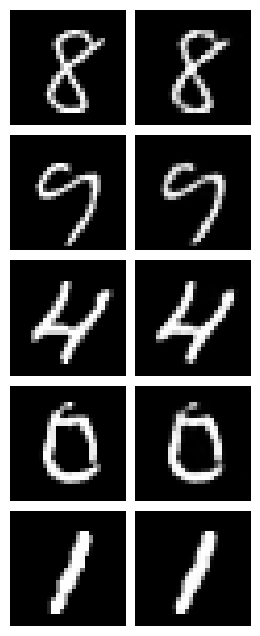

In [9]:
train_AE(model_AE, optimizer, epochs=20, device=device)
print_data_and_samples(model_AE)

This looks quite good, and we notice that the edges are fairly sharp.

In summary, the autoencoder has learned a compressed representation of the data, which is the output of the bottleneck layer. This compressed representation is a nonlinear dimensionality reduction of the data.

With this trained neural network you could *try* to generate new images by choosing points from the latent / bottleneck layer and passing it through the decoder. In general though, nothing in the problem ensures that the latent space is densely populated by the data, so this is not guaranteed to work. I encourage you to play around with this and try it, though!

# Variational Autoencoder

In contrast to an autoencoder, a variational autoencoder (VAE) is a generative model. Instead of encoding the input $x$ in a latent $z$, it actually models a distribution on the latent space. This is the distribution we wish to sample from to generate new data.

We will study a standard case where the distributionson the latents are normal, with a mean and variance that depend on $x$.

$z \sim \mathcal{N}(\mu(x), \sigma(x))$.

However, if we have stochastic later in the middle of the network, we can't backpropagate through it. To get around this, we use the reparameterization trick. We sample from a standard normal 

$\epsilon \sim \mathcal{N}(0, 1)$

 and then define 

$z = \mu(x) + \sigma(x) \epsilon$. 
 
This way, we can backpropagate through the encoder and decoder by taking the encoder of the AE and adding two extra layers that help it learn the mean and variance; this is the encoder of the VAE. Then, samples from the latent space are generated by sampling $\epsilon$ and passing it through the decoder.

Training proceeds via a loss with two components, the reconstruction loss and the KL divergence between the true distribution and the model distribution. In this case, we will use the original treatment of Kingma and Welling [https://arxiv.org/abs/1312.6114](https://arxiv.org/abs/1312.6114), that chooses a particular KL estimator suitable training the latent distribution to model the Gaussian.

In [10]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    # def forward(self, x):
    #     mean, logvar = self.encode(x)
    #     z = self.reparameterization(mean, logvar)
    #     x_hat = self.decode(z)
    #     return x_hat, mean, log_var

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

We include a KL dirgence term in our loss now.
Recall that
the KL divergence for two distributions is defined as:

$D_{\text{KL}}(q(z|x) \,||\, p(z)) = \int q(z|x) \log \frac{q(z|x)}{p(z)} \, dz$

For a Gaussian prior $p(z) = \mathcal{N}(0, I)$ and a variational posterior $q(z|x) = \mathcal{N}(\mu, \sigma^2)$, this simplifies to:

$D_{\text{KL}} = - \frac{1}{2} \sum \left(1 + \log \sigma^2 - \mu^2 - \sigma^2 \right)$

This formula is used to measure the difference between the approximate posterior and the prior distribution.


In [11]:
def loss_function_VAE(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

def train_VAE(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function_VAE(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [12]:
model_VAE = VAE().to(device)
optimizer = Adam(model_VAE.parameters(), lr=1e-3)

In [13]:
train_VAE(model_VAE, optimizer, epochs=20, device=device)

	Epoch 1 	Average Loss:  181.2089274441778
	Epoch 2 	Average Loss:  162.8715742709203
	Epoch 3 	Average Loss:  158.6915192638773
	Epoch 4 	Average Loss:  155.60423167844846
	Epoch 5 	Average Loss:  153.4445959248487
	Epoch 6 	Average Loss:  151.96570332063857
	Epoch 7 	Average Loss:  150.8600306989514
	Epoch 8 	Average Loss:  149.82799843815212
	Epoch 9 	Average Loss:  149.0806675024781
	Epoch 10 	Average Loss:  148.44470075451272
	Epoch 11 	Average Loss:  147.93158040092862
	Epoch 12 	Average Loss:  147.38728424327005
	Epoch 13 	Average Loss:  146.88799199838272
	Epoch 14 	Average Loss:  146.66980793183953
	Epoch 15 	Average Loss:  146.11377579168405
	Epoch 16 	Average Loss:  145.679591294736
	Epoch 17 	Average Loss:  145.5091288540797
	Epoch 18 	Average Loss:  145.2826592171849
	Epoch 19 	Average Loss:  144.885234375
	Epoch 20 	Average Loss:  144.53091456137835


8657401.782226562

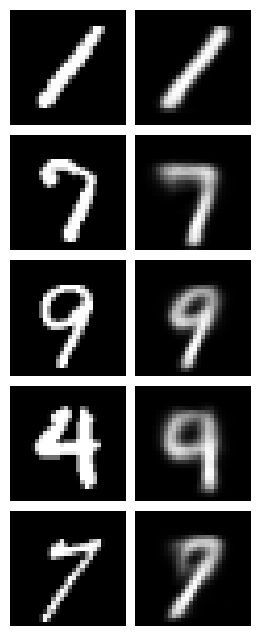

In [14]:
print_data_and_samples(model_VAE)

In [15]:
scale, n = 5.0, 5
print(np.linspace(-scale, scale, n))
print(np.linspace(-scale, scale, n)[::-1])

[-5.  -2.5  0.   2.5  5. ]
[ 5.   2.5  0.  -2.5 -5. ]


In [16]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1] # reverses order

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

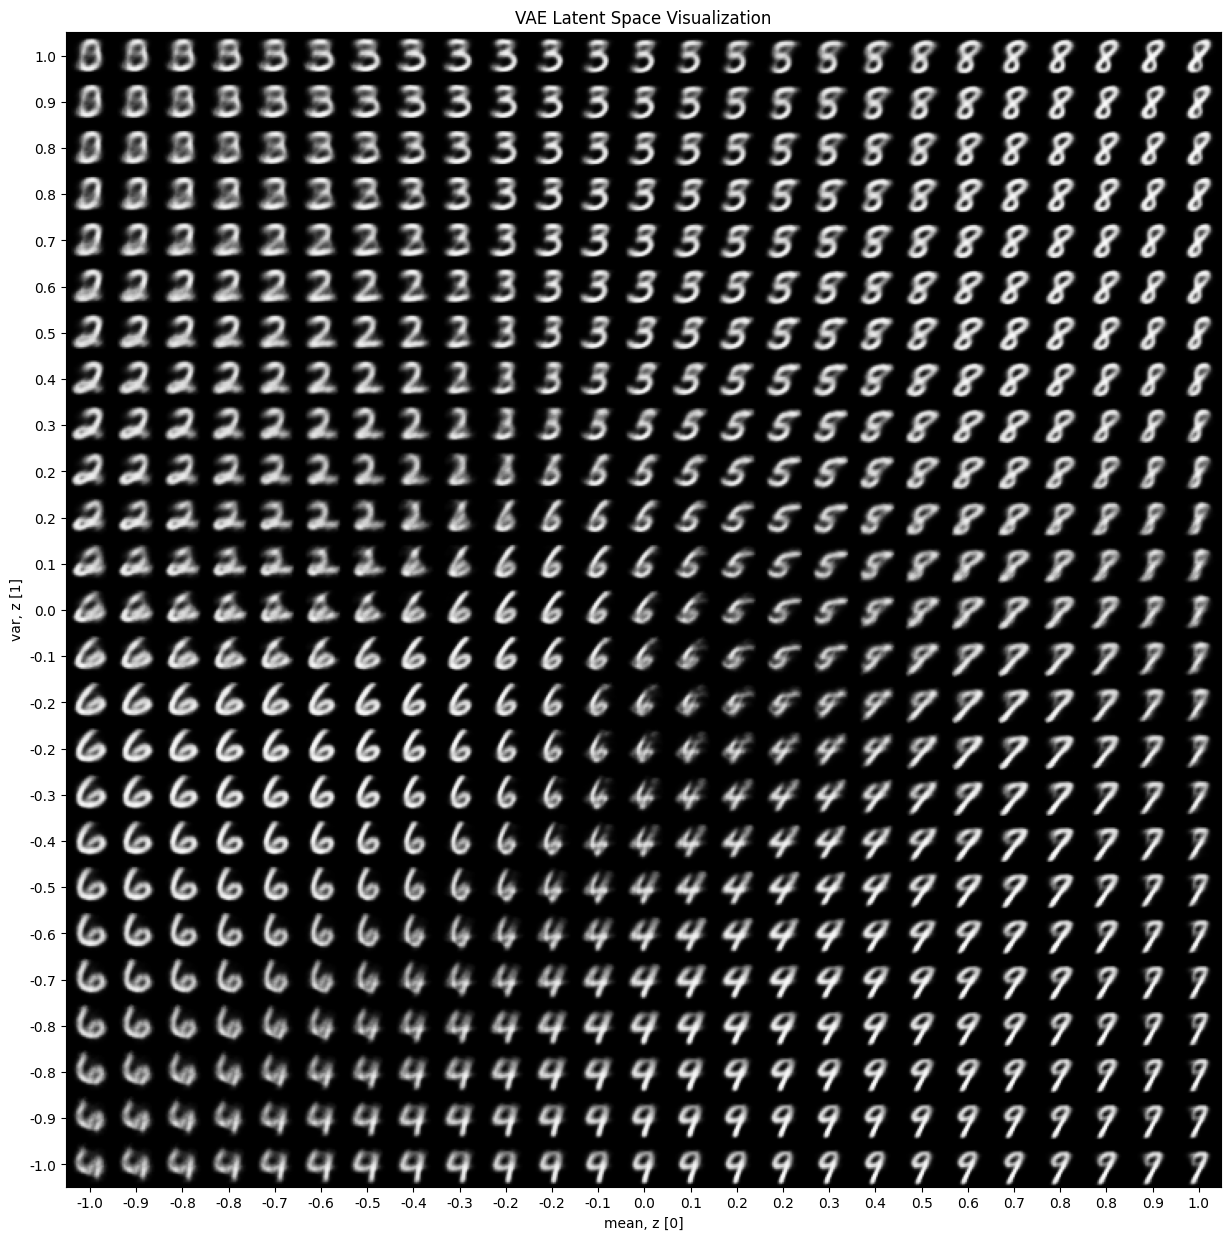

In [17]:
plot_latent_space(model_VAE, scale=1.0)

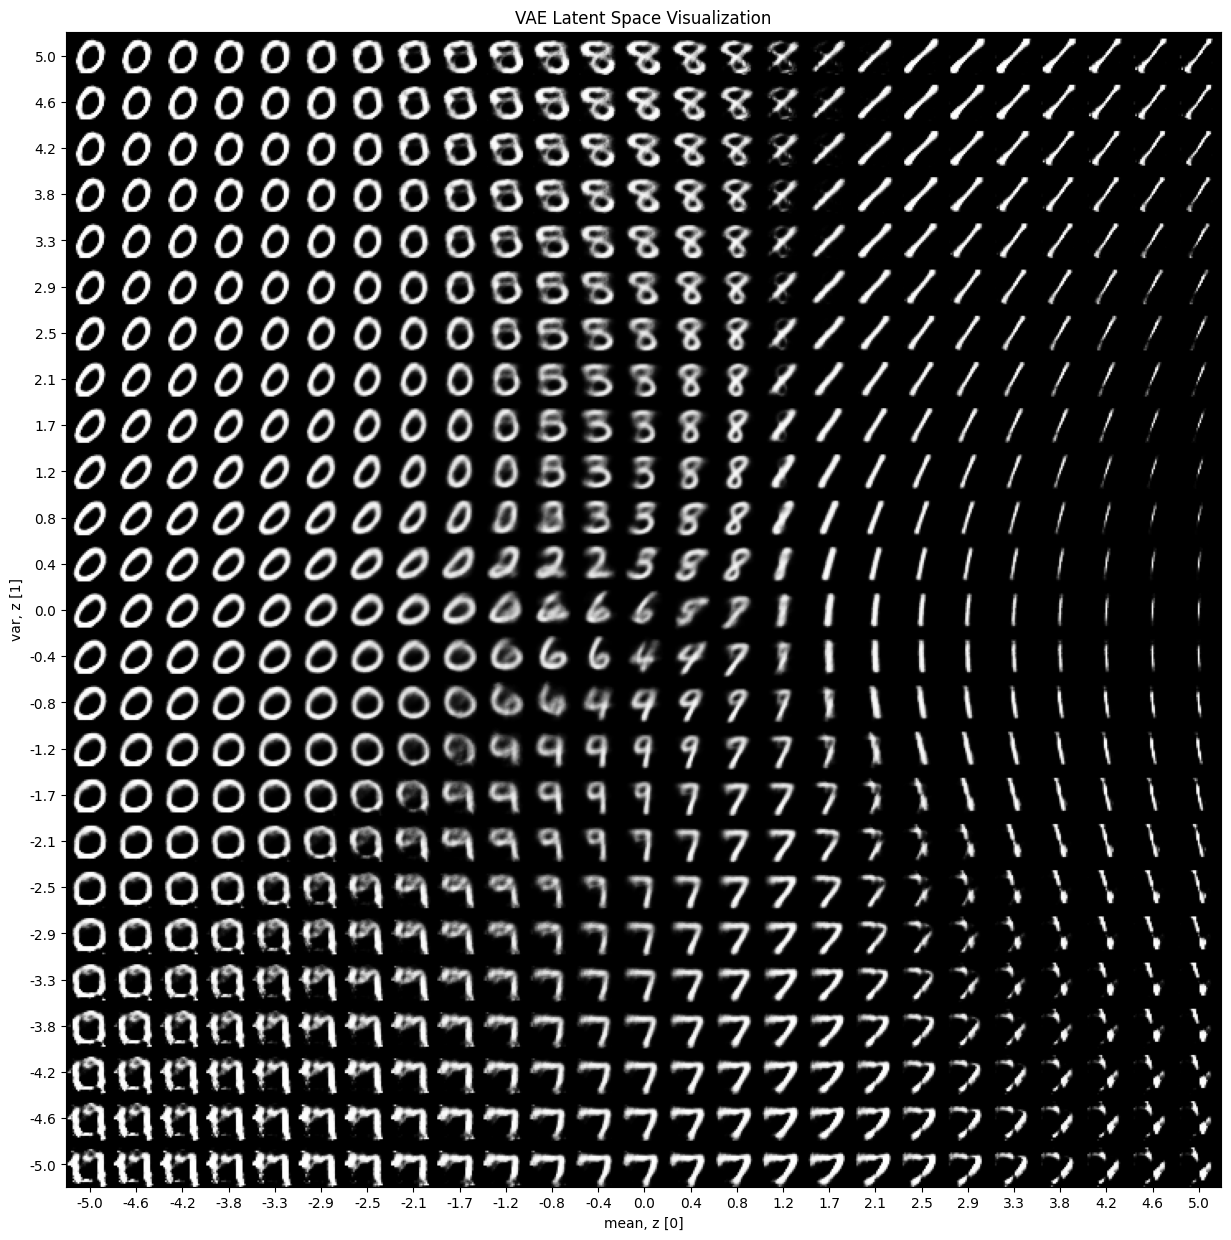

In [18]:
plot_latent_space(model_VAE, scale=5.0)

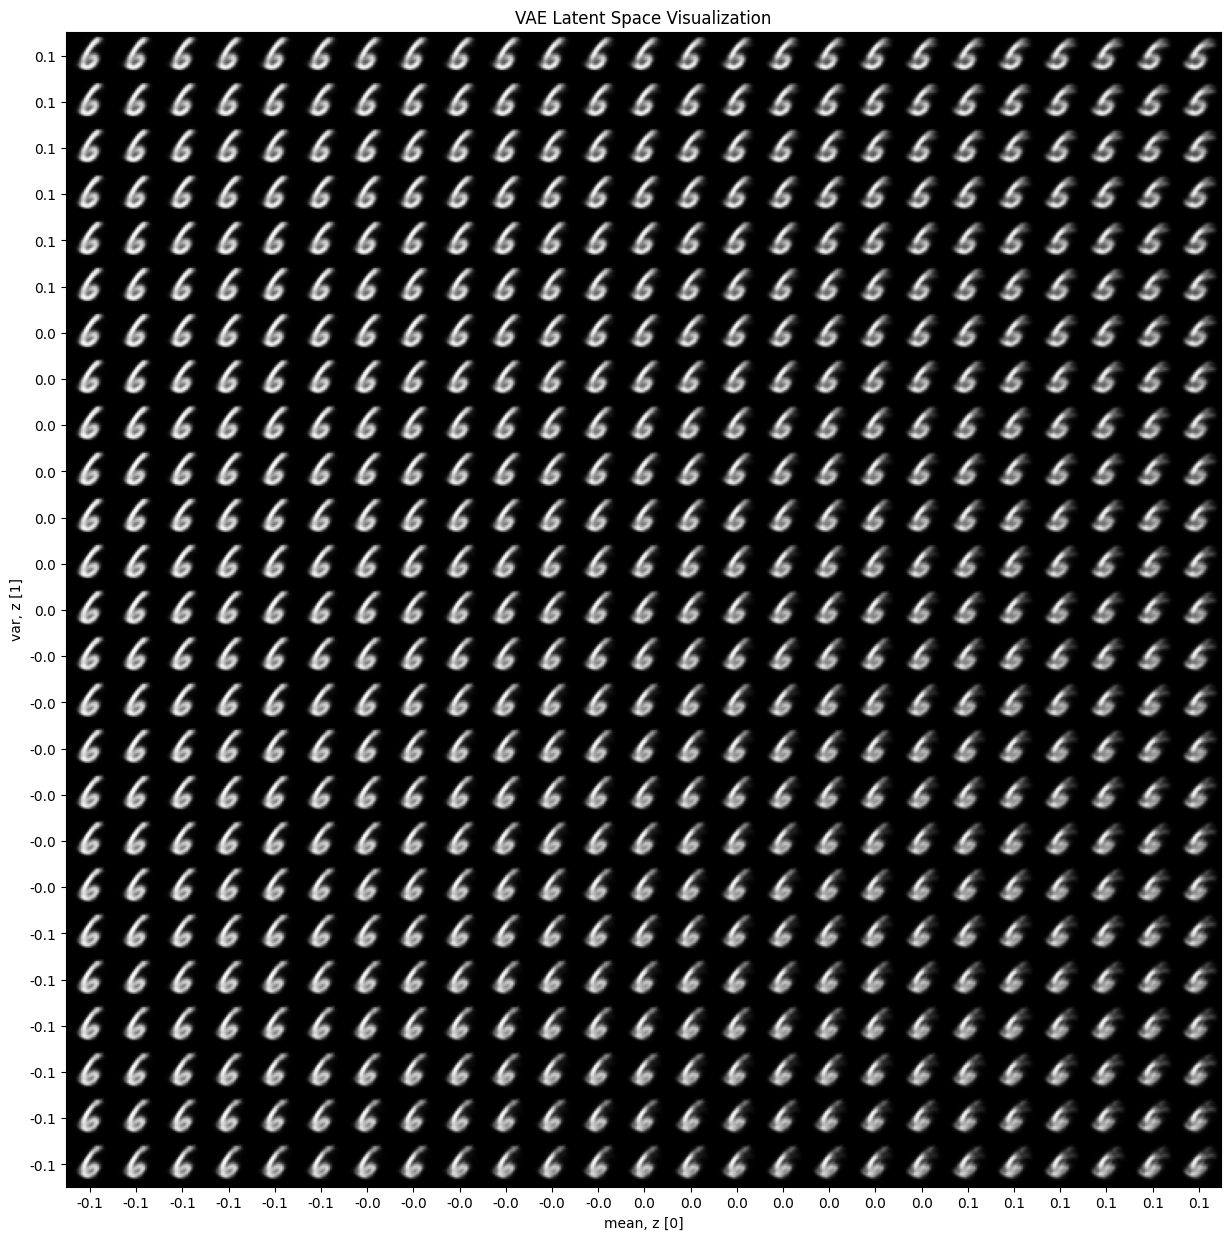

In [19]:
plot_latent_space(model_VAE, scale=.1)

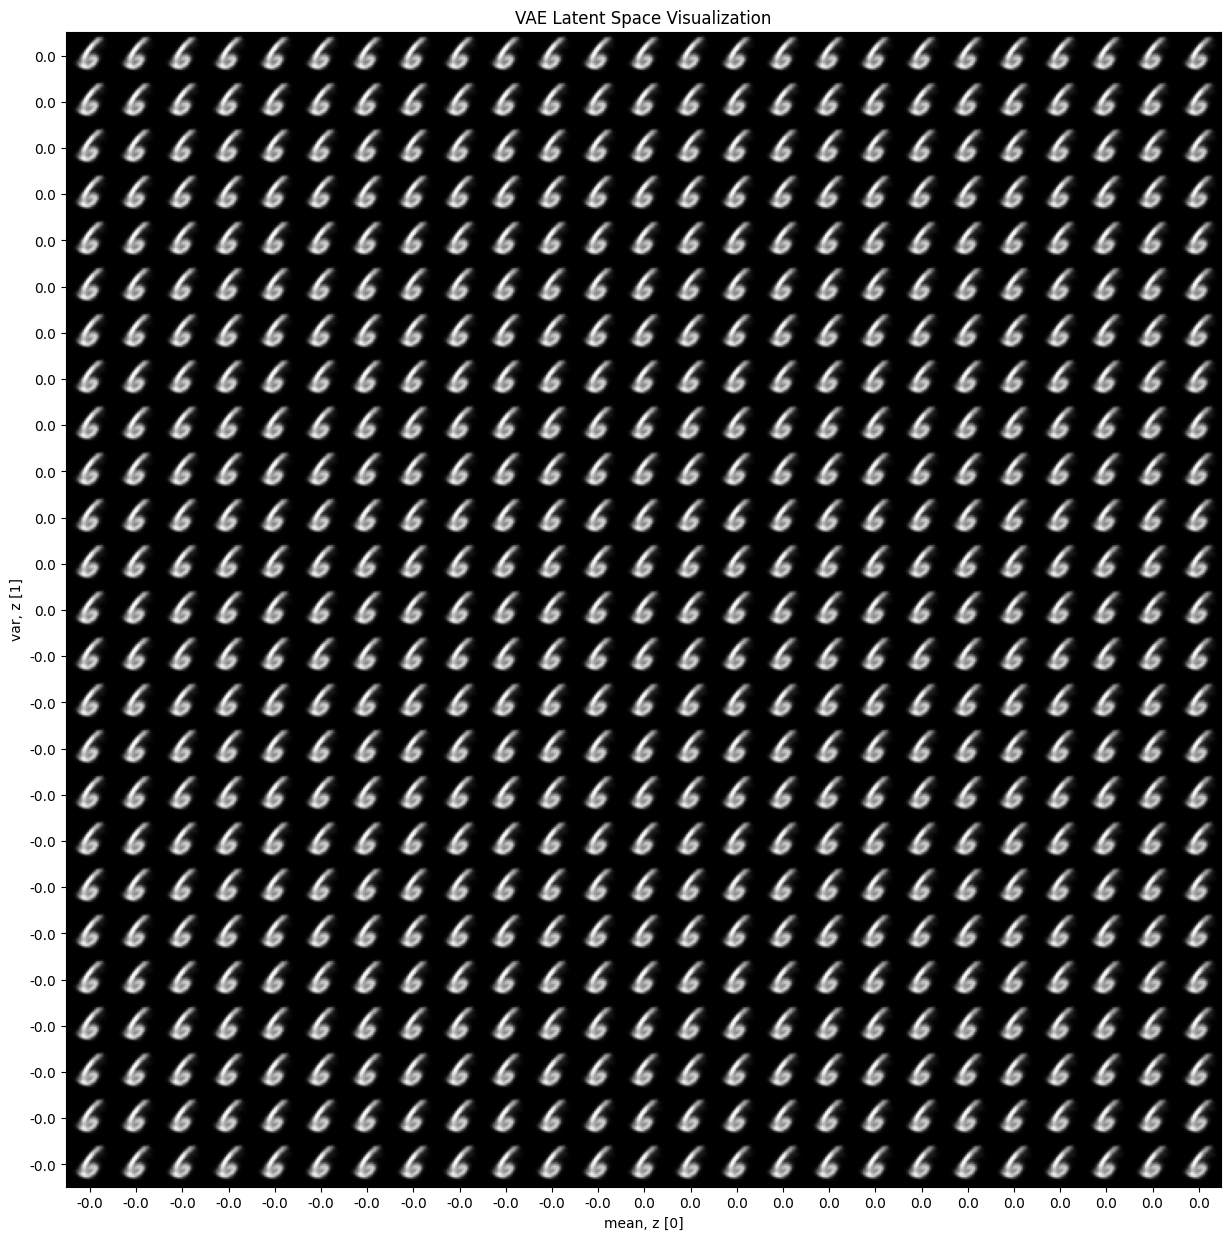

In [20]:
plot_latent_space(model_VAE, scale=.01)